## 라이브러리

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA

# 한글 처리
plt.rc("font", family = "Malgun Gothic")

# 기호 처리
plt.rcParams["axes.unicode_minus"] = False

---

## 자치구 가중치 추가

In [2]:
# 지하철역 군집분석 데이터 불러오기
df_subway = pd.read_csv('./data/02_지하철역_군집분석_데이터.csv', encoding='euc-kr')
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수
0,강서구청,14410.5,13697.1,479.20,3,3,강서구,대저1동,42,0,0
1,개금,41032.5,39863.2,36.64,3,2,부산진구,개금동,155,1,0
2,거제,29321.0,29071.2,16.00,1,3,연제구,거제동,67,1,0


자치구 가중치

| 항목 | 0 | 1 | 2 |
| ------ | ------ | ------ | ------ |
| 숙박 및 음식점 비율 낮은 순 | 2 | 1 | 3 |
| 보건업 및 복지 비율 높은 순 | 2 | 3 | 1 |
| 20대 인구 수 높은 순 | 2 | 3 | 1 |
| 녹지 개소 적은 순 | 2 | 3 | 1 |
| 인구 비율 높은 순 | 2 | 3 | 1 |
| 합계 | 10 | 13 | 7 |
| 자치구 가중치 | 0.5 | 1.0 | 0.0 |

In [3]:
# 자치구 가중치 컬럼 추가
df_subway['자치구가중치'] = 0.0

# 첫 번째 그룹에 대해 가중치 설정
df_subway.loc[df_subway['지번주소_구'].isin(['사하구', '연제구', '금정구', '동래구', '사상구', '남구', '수영구', '북구']), '자치구가중치'] = 0.5

# 두 번째 그룹에 대해 가중치 설정
df_subway.loc[df_subway['지번주소_구'].isin(['부산진구', '해운대구']), '자치구가중치'] = 1.0

# 세 번째 그룹에 대해 가중치 설정
df_subway.loc[df_subway['지번주소_구'].isin(['중구', '서구', '동구', '강서구', '기장군']), '자치구가중치'] = 0.5

In [4]:
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수,자치구가중치
0,강서구청,14410.5,13697.1,479.20,3,3,강서구,대저1동,42,0,0,0.5
1,개금,41032.5,39863.2,36.64,3,2,부산진구,개금동,155,1,0,1.0
2,거제,29321.0,29071.2,16.00,1,3,연제구,거제동,67,1,0,0.5


In [5]:
# 필요없는 컬럼 제거
df_sub_clust = df_subway.drop(columns=['역명', '지번주소_구', '지번주소_동'])
df_sub_clust.head(3)

,승차,하차,유휴공간_면적,유휴공간_수,선명,체력단련장수,대학수,원예학과수,자치구가중치
0,14410.5,13697.1,479.20,3,3,42,0,0,0.5
1,41032.5,39863.2,36.64,3,2,155,1,0,1.0
2,29321.0,29071.2,16.00,1,3,67,1,0,0.5


---

## KMeans

In [6]:
# 스케일링
ss = StandardScaler()
df_scaled = ss.fit_transform(df_sub_clust)

KElbowVisualizer(ax=<Axes: >, estimator=KMeans(n_clusters=29, n_init=10),
                 k=(1, 30))

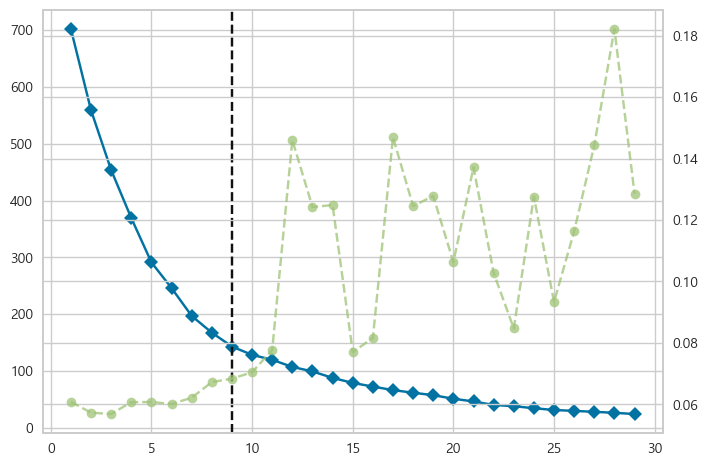

In [24]:
# 엘보우 기법
model = KMeans(n_init=10)
visualizer = KElbowVisualizer(model, k=(1,30))
visualizer.fit(df_scaled)

In [47]:
# 모델생성
km = KMeans(n_clusters=9, n_init=10, random_state=42)

# 훈련
km.fit(df_scaled)

# 군집 결과 확인
df_subway['clust'] = km.labels_

np.unique(km.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 array([22, 14,  1, 13,  3, 10,  9,  2,  4], dtype=int64))

In [48]:
# 실루엣 계수
silhouette_avg = silhouette_score(df_scaled, km.labels_)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.3286690300429843


In [49]:
# Kmeans 군집 결과
df_subway.head(3)

,역명,승차,하차,유휴공간_면적,유휴공간_수,선명,지번주소_구,지번주소_동,체력단련장수,대학수,원예학과수,자치구가중치,clust
0,강서구청,14410.5,13697.1,479.20,3,3,강서구,대저1동,42,0,0,0.5,3
1,개금,41032.5,39863.2,36.64,3,2,부산진구,개금동,155,1,0,1.0,1
2,거제,29321.0,29071.2,16.00,1,3,연제구,거제동,67,1,0,0.5,6


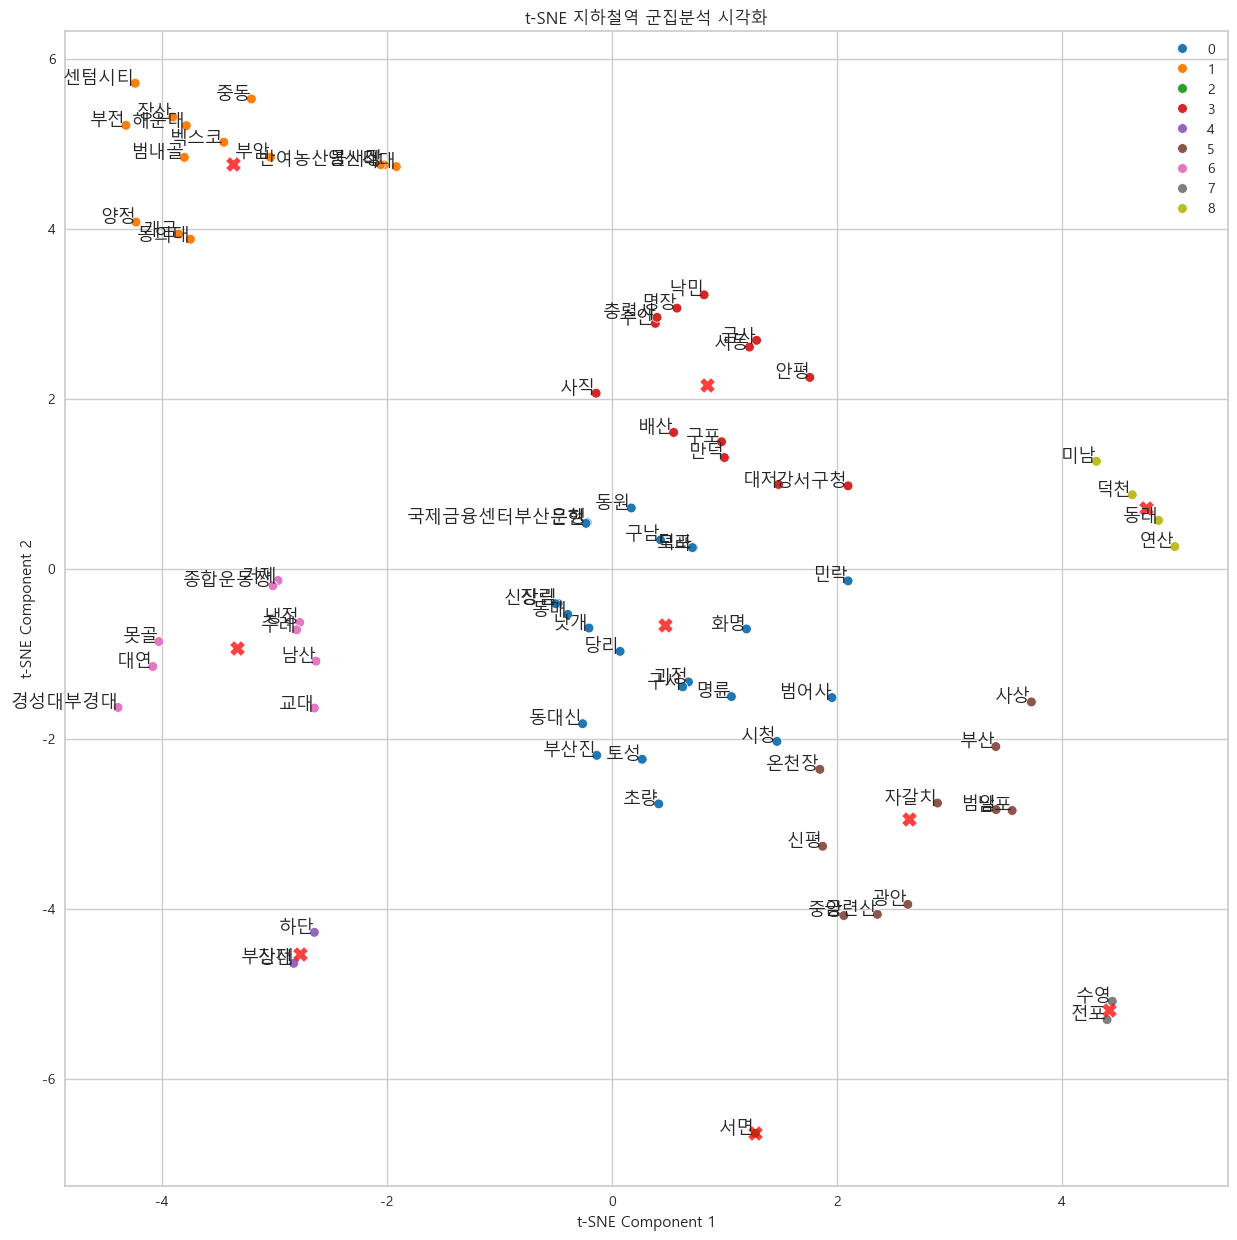

In [92]:
# 군집 결과 시각화
combined_data = pd.concat([pd.DataFrame(df_scaled), pd.DataFrame(km.cluster_centers_)])

# t-SNE 적용
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_tsne = tsne.fit_transform(combined_data)

X_tsne = combined_tsne[:-km.cluster_centers_.shape[0]]
centers_tsne = combined_tsne[-km.cluster_centers_.shape[0]:]

X_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
X_tsne = pd.concat([X_tsne, pd.DataFrame(df_scaled), df_subway[['역명']]], axis=1)

# 군집 레이블 추가
X_tsne['clust'] = km.labels_

# 그래프 그리기
plt.figure(figsize=(15, 15))
scatter = sns.scatterplot(data=X_tsne, x='TSNE1', y='TSNE2', hue='clust', s=50, palette='tab10')
plt.scatter(centers_tsne[:, 0], centers_tsne[:, 1], c='red', s=100, alpha=0.75, marker='X')

for i in range(X_tsne.shape[0]):
    plt.text(X_tsne['TSNE1'][i], X_tsne['TSNE2'][i], X_tsne['역명'][i], fontsize=13, ha='right')

plt.title('t-SNE 지하철역 군집분석 시각화')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.savefig('./savefig/tsne_지하철역군집분석_시각화.png')

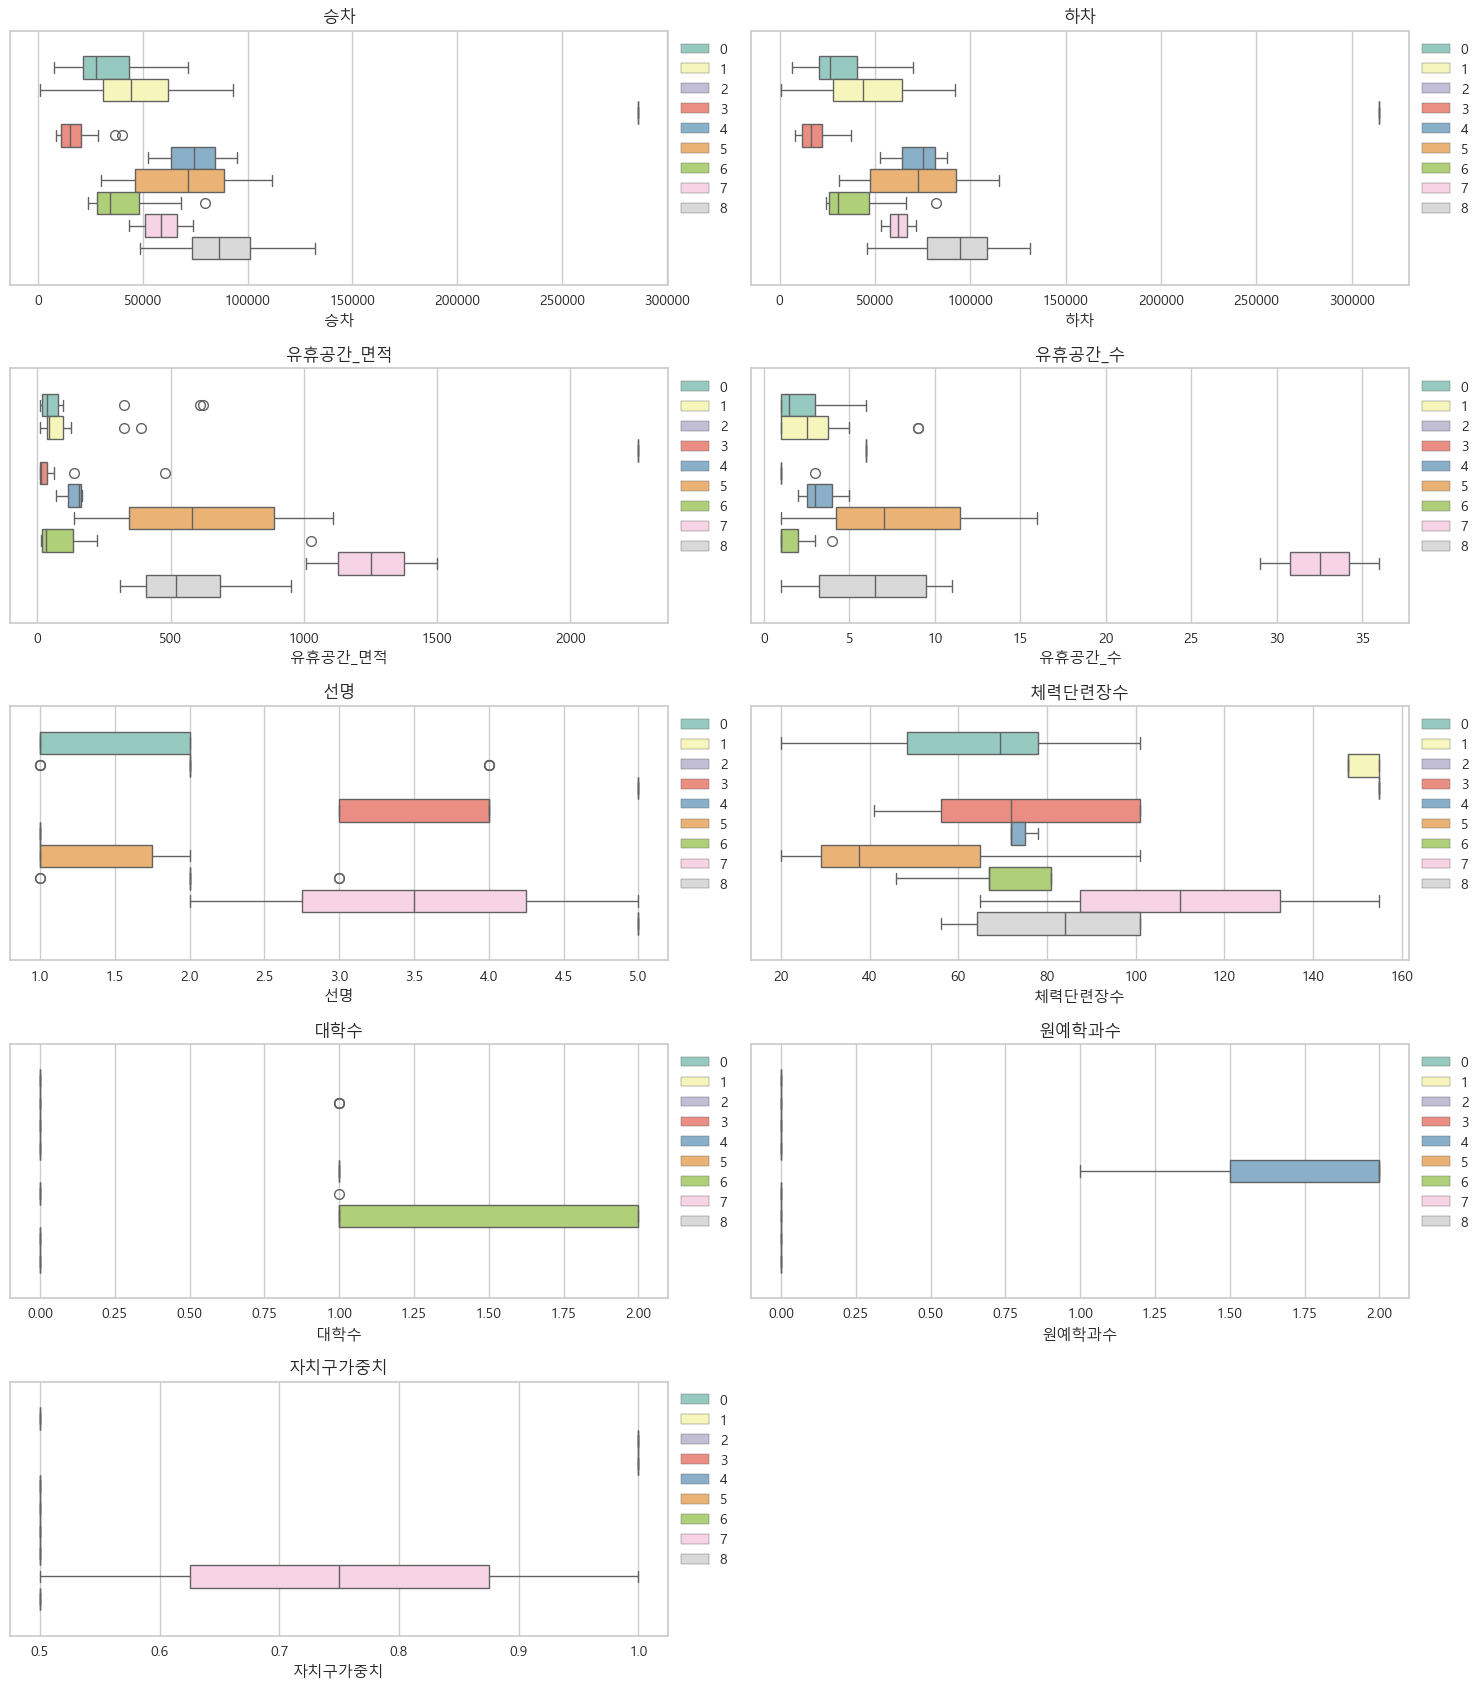

In [66]:
# 지하철역 군집분석 컬럼 시각화
i = 1
plt.figure(figsize=(15,20))

df_sub_clust['clust'] = km.labels_

for val in df_sub_clust.columns[:-1]:
    plt.subplot(6,2,i)
    sns.boxplot(data=df_sub_clust, x=val, hue='clust', palette='Set3')
    plt.title(val)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    i += 1
plt.savefig('./savefig/지하철역군집분석컬럼시각화.png')

In [75]:
# 중앙값 출력
dic = {}
for i in range(9):
    b = df_sub_clust[df_sub_clust['clust']==i]['자치구가중치'].describe()['50%']
    dic[i] = b
sorted_dict = dict(sorted(dic.items(), key=lambda item: item[1]))
sorted_dict

{0: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5, 8: 0.5, 7: 0.75, 1: 1.0, 2: 1.0}

In [90]:
# 주어진 데이터를 딕셔너리로 저장
station_dict = {}
X_tsne_split = X_tsne.iloc[:, -2:]

for i in range(9):
    cluster_data = X_tsne_split[X_tsne_split['clust'] == i]
    station_dict[i] = [val for val in cluster_data['역명']]

# key와 value를 각각 'key'와 'value' 컬럼으로 변환하여, value를 콤마로 연결하여 표현
df = pd.DataFrame({
    '군집': list(station_dict.keys()), 
    '역명': [', '.join(values) for values in station_dict.values()]
})
df

,군집,역명
0,0,"괴정, 구남, 구서, 국제금융센터부산은행, 낫개, 당리, 덕포, 동대신, 동매, 동..."
1,1,"개금, 동의대, 반여농산물시장, 범내골, 벡스코, 부암, 부전, 석대, 센텀시티, ..."
2,2,서면
3,3,"강서구청, 구포, 금사, 낙민, 대저, 만덕, 명장, 배산, 사직, 서동, 수안, ..."
4,4,"부산대, 장전, 하단"
5,5,"광안, 금련산, 남포, 범일, 부산, 사상, 신평, 온천장, 자갈치, 중앙"
6,6,"거제, 경성대부경대, 교대, 남산, 냉정, 대연, 못골, 종합운동장, 주례"
7,7,"전포, 수영"
8,8,"덕천, 동래, 미남, 연산"


In [91]:
# 최종결과 저장
df.to_csv('./최종군집결과.csv', encoding='euc-kr', index=False)

### 

| 항목                   | 0  | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  |
|------------------------|----|----|----|----|----|----|----|----|----|
| 승하차 인원수 많은 순  | 2  | 4  | 9  | 1  | 7  | 6  | 3  | 5  | 8  |
| 체력단련장 수 많은 순  | 3  | 8  | 9  | 4  | 4  | 1  | 2  | 7  | 6  |
| 대학 수 많은 순        | 1  | 1  | 1  | 1  | 9  | 1  | 9  | 1  | 1  |
| 원예관련학과 수 많은 순| 1  | 1  | 1  | 1  | 9  | 1  | 1  | 1  | 1  |
| 유휴공간 수 많은 순    | 3  | 4  | 6  | 1  | 5  | 8  | 1  | 9  | 7  |
| 유휴공간 면적 넓은 순  | 3  | 4  | 9  | 1  | 5  | 7  | 2  | 8  | 6  |
| 자치구 가중치 높은 순  | 1  | 9  | 9  | 1  | 1  | 1  | 1  | 5  | 1  |
| **합계**               | **14** | **31** | **44** | **10** | **40** | **25** | **19** | **36** | **30** |


상위 3개의 군집을 입지로 선정: 2, 4, 7
- 군집 2: 서면
- 군집 4: 부산대, 장전, 하단
- 군집 7: 전포, 수영